100%|██████████| 9.91M/9.91M [00:00<00:00, 34.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.00MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]


[HM] Epoch 1, Loss: 0.0296
[HM] Epoch 2, Loss: 0.0114
[HM] Epoch 3, Loss: 0.0089
[HM] Epoch 4, Loss: 0.0078
[HM] Epoch 5, Loss: 0.0071
[C2HM] Epoch 1, Loss: 0.0357
[C2HM] Epoch 2, Loss: 0.0161
[C2HM] Epoch 3, Loss: 0.0126
[C2HM] Epoch 4, Loss: 0.0109
[C2HM] Epoch 5, Loss: 0.0098
Reconstruction Loss on Noisy Data:
HM: 0.0661
C2HM: 0.0409


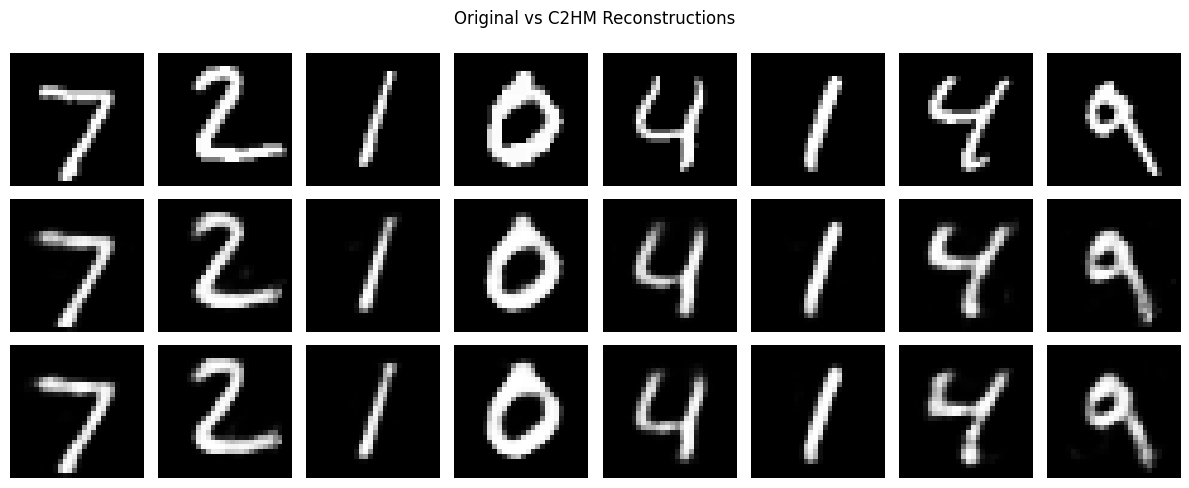

In [1]:
# ✅ C²HM Benchmark Suite (Colab-ready)
# Extends HM ↔ IHM loop model with evaluations for:
# - Partial inference (progressive masking)
# - Noise robustness
# - Latent classification
# - Cycle convergence
# - Comparison to original HM
# ===========================

!pip install -q torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading
transform = transforms.ToTensor()
train_set = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Encoder and Decoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

# HM and IHM components
class HM(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

class IHM(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

# Setup both original HM and C2HM models
latent_dim = 32
hm_original = HM(latent_dim).to(device)  # Original HM for baseline
hm = HM(latent_dim).to(device)           # HM part of C2HM
ihm = IHM(latent_dim).to(device)         # IHM part of C2HM

# === Train original HM ===
optimizer_hm = optim.Adam(hm_original.parameters(), lr=1e-3)
criterion = nn.MSELoss()
for epoch in range(5):
    hm_original.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        z = hm_original.encoder(x)
        x_recon = hm_original.decoder(z)
        loss = criterion(x_recon, x)
        optimizer_hm.zero_grad()
        loss.backward()
        optimizer_hm.step()
        total_loss += loss.item()
    print(f"[HM] Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# === Train C2HM ===
params = list(hm.parameters()) + list(ihm.parameters())
optimizer = optim.Adam(params, lr=1e-3)

lambda_z = 0.01
lambda_x = 0.1

for epoch in range(5):
    hm.train()
    ihm.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        z = hm.encoder(x)
        x_hat = hm.decoder(z)
        z_cycle = ihm.encoder(x_hat.detach())
        x_cycle = ihm.decoder(z_cycle)
        z_double = hm.encoder(x_cycle.detach())
        x_double = hm.decoder(z_double)
        loss_recon = criterion(x_hat, x)
        loss_loop = criterion(x_double, x)
        loss_latent = nn.functional.mse_loss(z, z_cycle)
        loss = loss_recon + lambda_x * loss_loop + lambda_z * loss_latent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[C2HM] Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# ========== BENCHMARK: Side-by-side comparison on noise ==========
def evaluate_models_on_noise(hm1, hm2, label1="HM", label2="C2HM"):
    def compute_loss(model):
        model.eval()
        loss = 0
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                noise = torch.randn_like(x) * 0.4
                x_noisy = torch.clamp(x + noise, 0., 1.)
                z = model.encoder(x_noisy)
                x_recon = model.decoder(z)
                loss += criterion(x_recon, x).item()
        return loss / len(test_loader)

    loss1 = compute_loss(hm1)
    loss2 = compute_loss(hm2)
    print(f"Reconstruction Loss on Noisy Data:\n{label1}: {loss1:.4f}\n{label2}: {loss2:.4f}")

evaluate_models_on_noise(hm_original, hm)

# ========== BENCHMARK: Visual comparison of reconstructions ==========
x_sample, _ = next(iter(test_loader))
x_sample = x_sample[:8].to(device)

with torch.no_grad():
    x_hm = hm_original.decoder(hm_original.encoder(x_sample))
    x_c2hm = hm.decoder(hm.encoder(x_sample))

fig, axes = plt.subplots(3, 8, figsize=(12, 5))
for i in range(8):
    axes[0, i].imshow(x_sample[i].detach().cpu().squeeze(), cmap='gray')
    axes[1, i].imshow(x_hm[i].detach().cpu().squeeze(), cmap='gray')
    axes[2, i].imshow(x_c2hm[i].detach().cpu().squeeze(), cmap='gray')
    for j in range(3):
        axes[j, i].axis('off')
axes[0, 0].set_ylabel("Input")
axes[1, 0].set_ylabel("HM")
axes[2, 0].set_ylabel("C2HM")
plt.suptitle("Original vs C2HM Reconstructions")
plt.tight_layout()
plt.show()
